<a href="https://colab.research.google.com/github/mz-zarei/NBEB-Sensitivity/blob/main/NBEB_sensitivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
#----------------------------------------------------------------------------
# Created By  : Mohammad Zarei
# Created Date: 10 Apr 2020
# ---------------------------------------------------------------------------
"""Implentation of propsoed method to determine network screening sensitivity to AADT error"""
# ---------------------------------------------------------------------------
# Imports
import nbeb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def DPSI(results):
    DPSI_test = 0
    for HS_level in [0.1]:
        DPSI_test += results[results['true_rank'] > 1-HS_level]['PSI_true'].sum() - results[results['rank'] > 1-HS_level]['PSI_true'].sum()
    return round(DPSI_test,3)

def FI(results):
    FI_test = 0
    for HS_level in [0.1]:
        FI_test += 1-results[(results['true_rank'] > 1- HS_level) & (results['rank'] > 1- HS_level)].count()[0]/results[(results['rank'] > 1- HS_level)].count()[0]
    return round(FI_test, 3)

def truncnorm(AADT_list, noise):
    AADT_n = []
    
    for mean in AADT_list:
        if noise > 0:
            sd = mean * noise
            minS = max(40, mean - 2*sd)
            maxS = mean + 2*sd
            while True:
                s = np.random.normal(mean, sd)
                if minS <= s <= maxS:
                    break
            AADT_n.append(s)  
        else:
            AADT_n.append(mean)


    return AADT_n


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
### Upload data
WA_data = pd.read_excel('/content/drive/MyDrive/GAN_regression/ganRegression/UrbanFreeWay4laneDivided.xlsx')
WA_data = WA_data[WA_data['year'] == 2017].copy()
WA_data['log_AADT'] = np.log(WA_data['AADT'])

WA_data.drop_duplicates(subset = 'log_AADT', inplace=True)
WA_data.reset_index(inplace=True, drop= True)

In [3]:
NB_model, alpha = nbeb.fitNB(WA_data,features=['log_AADT'], y_name='TotalCrash')
print(alpha, "\n", NB_model.summary())

2.650842866823885 
                  Generalized Linear Model Regression Results                  
Dep. Variable:             TotalCrash   No. Observations:                  420
Model:                            GLM   Df Residuals:                      418
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -705.37
Date:                Thu, 07 Apr 2022   Deviance:                       339.46
Time:                        16:27:41   Pearson chi2:                     536.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -12.1496      1.617

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:

noiseList = [0, 0.2, 0.4, 0.6, 0.8, 1]
var_list = [3, 1.5, 0.5, 0.25]
const_list = [-13.1496, -12.1496, -11.1496, -10.3496]
size_list = [250, 500, 1000]

FI_list  = []
DPSI_list = []
FI_noNoise_list  = []
DPSI_noNoise_list = []
data_size_list = []
error_var_list = []
constant_list = []
nosie_list = []
for constant in const_list:
    for error_var in var_list:
        for data_size in size_list:
            print(constant, data_size, error_var)
            for j in tqdm(range(200)):
                simulated_data = nbeb.simulateCrashData_X(WA_data['log_AADT'], 
                                                        constant = constant, 
                                                        coef_vector = [1.1822], 
                                                        data_size =  data_size, 
                                                        error_mean = 1.0,
                                                        error_var = error_var,
                                                        replacement = True)


                NB_model, alpha = nbeb.fitNB(simulated_data,features=['log_AADT'], y_name='Obs')

                simulated_data['NB_pred_true'] = np.exp(1.1822*simulated_data['log_AADT'] + constant)
                simulated_data['PSI_true'] = simulated_data['Lambda'] - simulated_data['NB_pred_true']
                simulated_data.loc[simulated_data['PSI_true']<0, 'PSI_true'] = 0
                simulated_data['true_rank'] = simulated_data['PSI_true'].rank(pct = True)

                simulated_data['NB_pred'] = nbeb.predNB(NB_model, simulated_data, ['log_AADT'], 'Obs')
                simulated_data['rank'] = nbeb.NBPSIranking(simulated_data, alpha, 'Obs')
                simulated_data['AADT'] = np.exp(simulated_data['log_AADT'])

                FI_NoNoise = FI(simulated_data)
                DPSI_NoNoise = DPSI(simulated_data)

                
                for i in range(1):
                    for noise in noiseList:

                        simulated_data['AADT_n'] = truncnorm(simulated_data['AADT'].values, noise)
                        simulated_data['log_AADT_n'] = np.log(simulated_data['AADT_n'])

                        NB_model, alpha = nbeb.fitNB(simulated_data,features=['log_AADT_n'], y_name='Obs')
                        
                        simulated_data['NB_pred'] = nbeb.predNB(NB_model, simulated_data, ['log_AADT_n'], 'Obs')
                        simulated_data['rank'] = nbeb.NBPSIranking(simulated_data, alpha, 'Obs')
                        
                        
                        FI_test  = FI(simulated_data)
                        DPSI_test = DPSI(simulated_data)
                        
                        FI_list.append((FI_test))
                        DPSI_list.append((DPSI_test))

                        FI_noNoise_list.append((FI_NoNoise))
                        DPSI_noNoise_list.append((DPSI_NoNoise))

                        data_size_list.append(data_size)
                        error_var_list.append(error_var)
                        constant_list.append(constant)
                        nosie_list.append(noise)



In [16]:
for i in  [-13.1496, -12.1496, -11.1496, -10.3496]:
    print(np.exp(1.1822*10.8+i))

0.6826042611503053
1.8555107591135875
5.043801179008714
11.225185959062443


In [6]:
Test_results = pd.DataFrame()
Test_results['Dispersion'] = error_var_list
Test_results['Mean'] = constant_list
Test_results.loc[Test_results.Mean == -10.3496, 'Mean'] = 11.3
Test_results.loc[Test_results.Mean == -11.1496, 'Mean'] = 5.1
Test_results.loc[Test_results.Mean == -12.1496, 'Mean'] = 1.9
Test_results.loc[Test_results.Mean == -13.1496, 'Mean'] = 0.7


Test_results['Sample Size'] = data_size_list
Test_results['COV (%)'] = nosie_list
Test_results['COV (%)'] = Test_results['COV (%)'] * 100

Test_results['FI'] = FI_list
Test_results['FI_NoNoise'] = FI_noNoise_list
Test_results['FI change (%)'] = (Test_results['FI']-Test_results['FI_NoNoise'])/Test_results['FI_NoNoise'] * 100

Test_results['DPSI'] = DPSI_list
Test_results['DPSI_NoNoise'] = DPSI_noNoise_list
Test_results['DPSI change (%)'] = Test_results['DPSI']-Test_results['DPSI_NoNoise']





Test_results.to_excel('test.xlsx')
Test_results

,Dispersion,Mean,Sample Size,COV (%),FI,FI_NoNoise,FI change (%),DPSI,DPSI_NoNoise,DPSI change (%)
0,3.00,0.7,250,0.0,0.40,0.40,0.000000,15.671,15.671,0.000
1,3.00,0.7,250,20.0,0.40,0.40,0.000000,15.671,15.671,0.000
2,3.00,0.7,250,40.0,0.36,0.40,-10.000000,10.670,15.671,-5.001
3,3.00,0.7,250,60.0,0.40,0.40,0.000000,15.976,15.671,0.305
4,3.00,0.7,250,80.0,0.40,0.40,0.000000,15.671,15.671,0.000
...,...,...,...,...,...,...,...,...,...,...
57595,0.25,11.3,1000,20.0,0.29,0.26,11.538462,185.089,158.938,26.151
57596,0.25,11.3,1000,40.0,0.34,0.26,30.769231,233.651,158.938,74.713
57597,0.25,11.3,1000,60.0,0.35,0.26,34.615385,247.942,158.938,89.004
57598,0.25,11.3,1000,80.0,0.36,0.26,38.461538,270.506,158.938,111.568


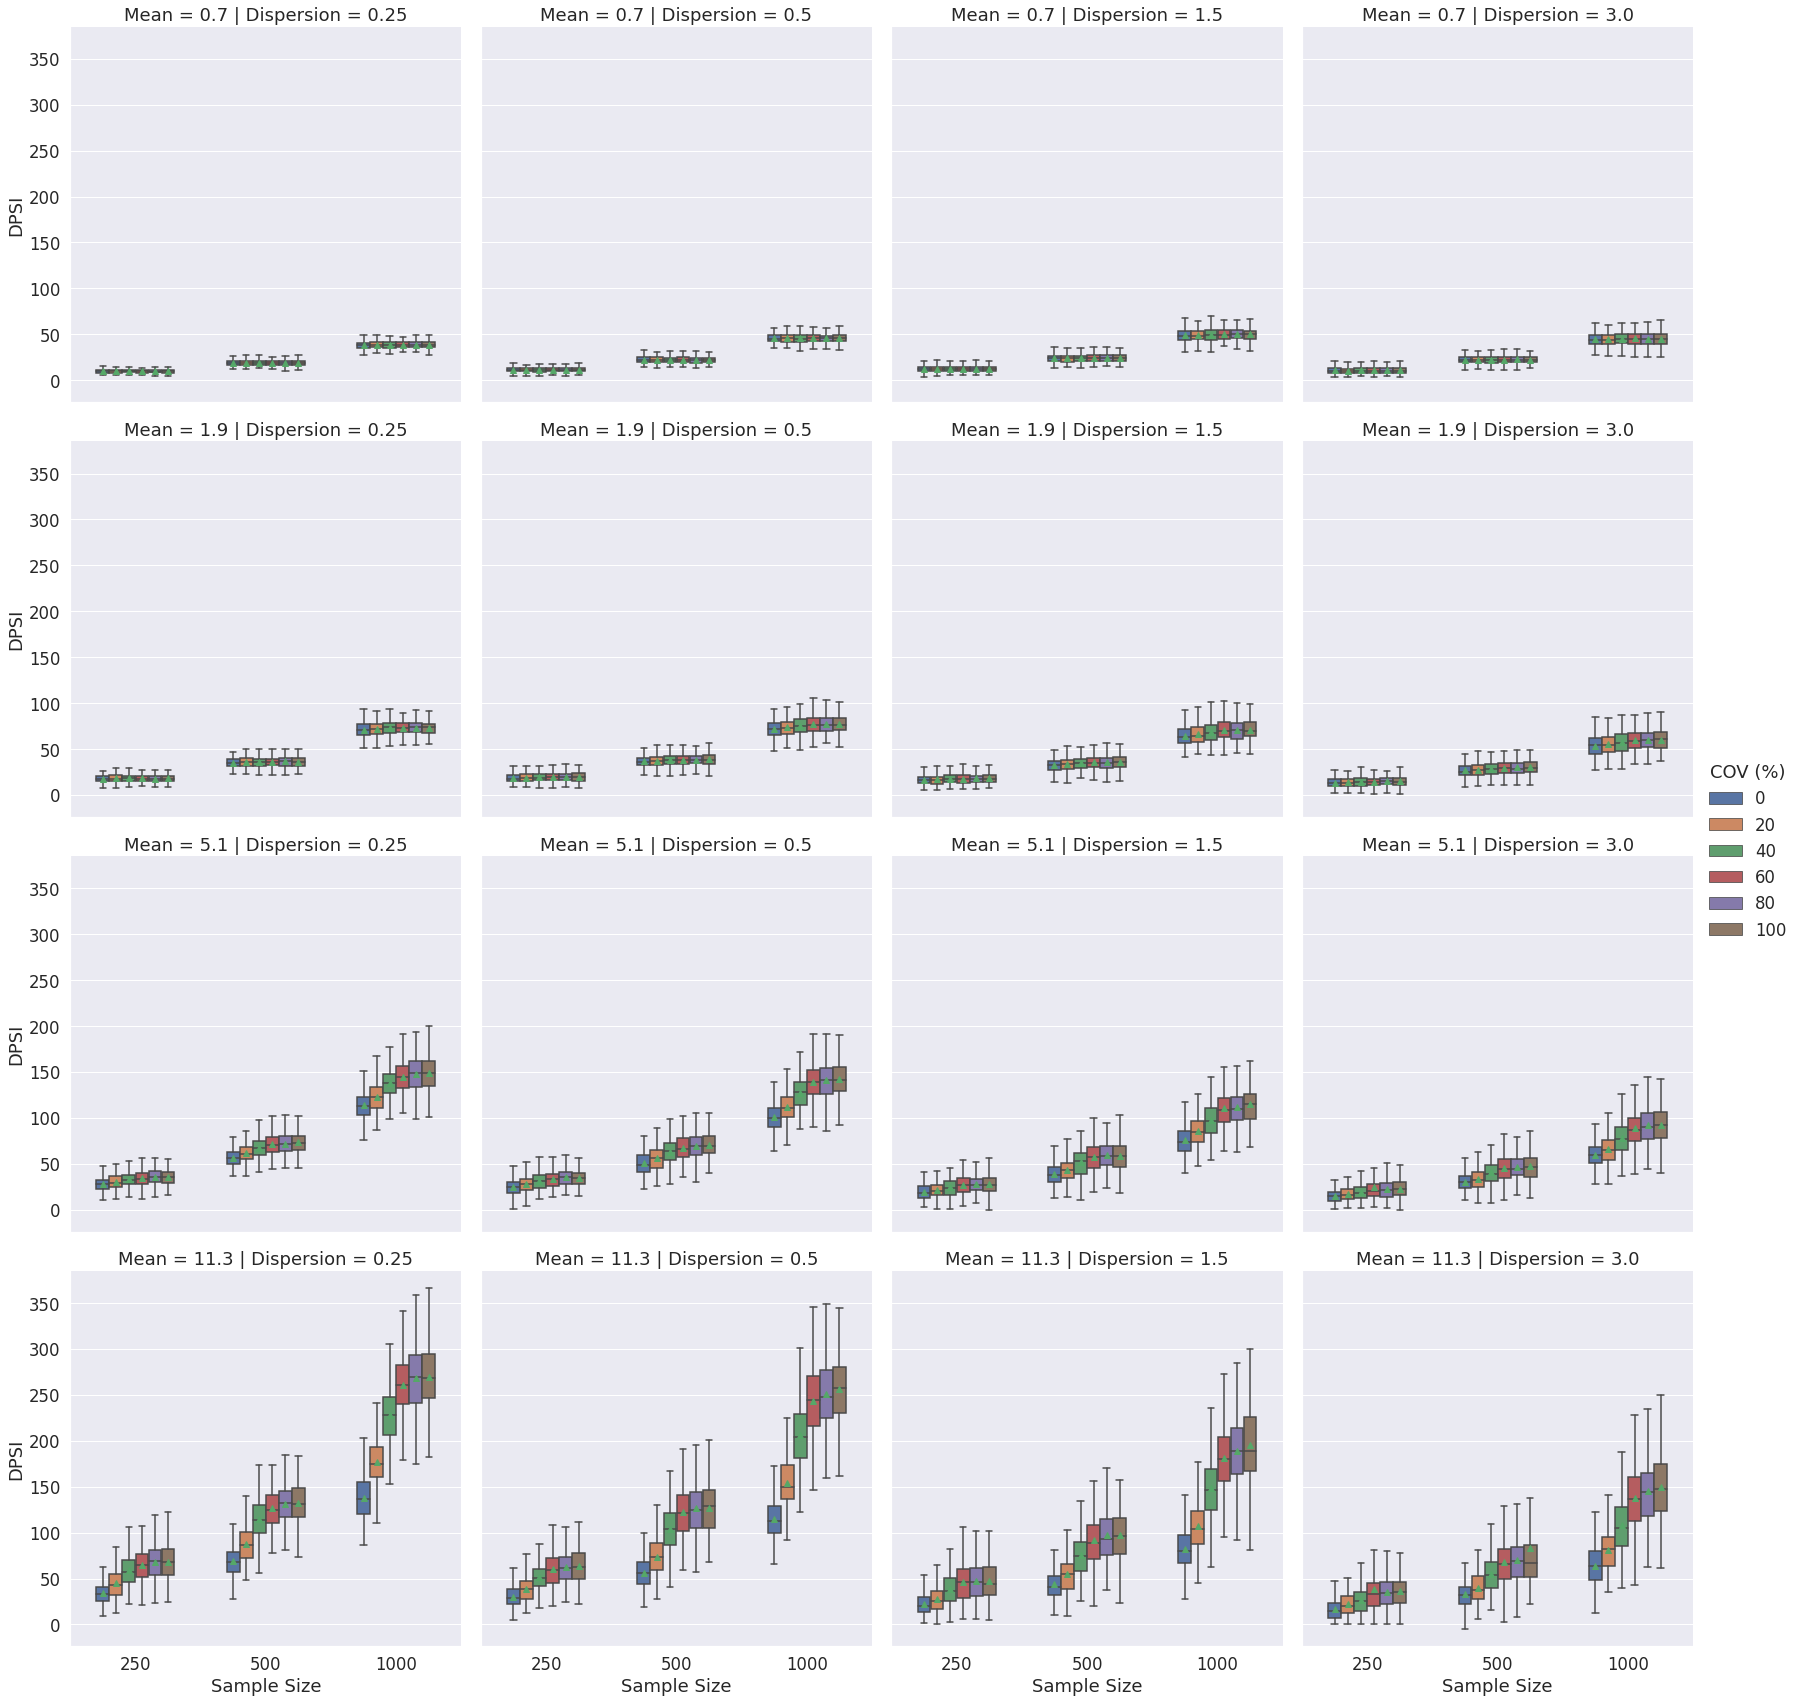

In [7]:
import seaborn as sns
sns.set(font_scale=1.5)
# Test_results = pd.read_excel('./test.xlsx')
Test_results = pd.read_excel('./Sens_result.xlsx', sheet_name='Sheet1')
fig = sns.catplot(data=Test_results, x="Sample Size", y="DPSI", hue = "COV (%)", width=0.6, col="Dispersion", row= "Mean", kind="box", height=6, aspect=1, showfliers=False, showmeans=True)
fig.savefig('DPSI.pdf')
plt.show()

# fig = sns.catplot(data=Test_results, x="Sample Size", y="FI", hue = "COV (%)", width=0.6, col="Dispersion", row= "Mean", kind="box", height=6, aspect=1, showfliers=False, showmeans=True)
# fig.savefig('FI.pdf')
# plt.show()

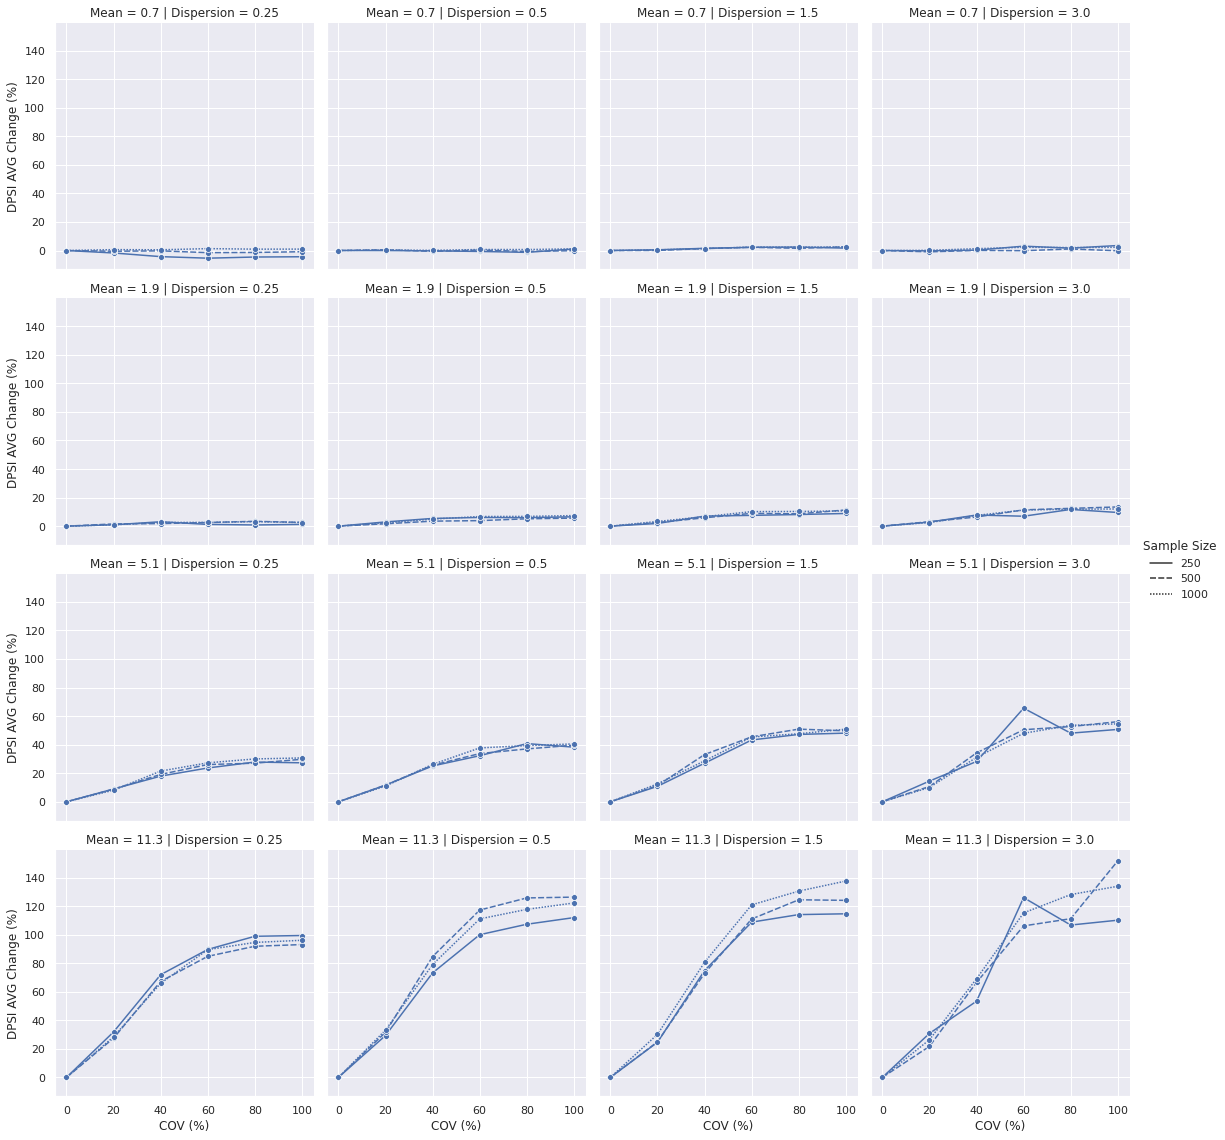

In [8]:
import seaborn as sns
sns.set(font_scale=1)
Test_results = pd.read_excel('./Sens_result.xlsx', sheet_name='Sheet2')
fig = sns.relplot(data=Test_results, x="COV (%)", y="DPSI AVG Change (%)", style = "Sample Size", col="Dispersion",
                  row= "Mean", kind="line", height=4, aspect=1, marker = 'o')
fig.savefig('DPSI_change.pdf')
plt.show()